In [1]:
library(dplyr, warn=F)
library(ggplot2)

## Prepare acceptance and publication delay dataframes

In [177]:
# Read history dates for all articles
path = file.path('data', 'articles-all.tsv.bz2')
col_types = list(
  accepted = readr::col_date(),
  received = readr::col_date(),
  date_online = readr::col_date(),
  revised = readr::col_date()
)
all_df = readr::read_tsv(path, col_types = col_types)
head(all_df, 2)

,journal,journal_nlm_id,pubmed_id,accepted,journal_issn,received,date_online,aheadofprint,revised,epublish,pmc-release,ecollection,ppublish,medline,pubmed,entrez
1,Arch Gerontol Geriatr,8214379,2416282,1985-05-02,0167-4943,1985-01-25,NA,NA,1985-04-30,NA,NA,NA,NA,NA,NA,NA
2,Arch Gerontol Geriatr,8214379,2421656,1985-09-19,0167-4943,1985-01-22,NA,NA,1985-09-18,NA,NA,NA,NA,NA,NA,NA


In [179]:
# Set time constraint to elimate erroneous records
earliest = readr::parse_date('1950-01-01')
latest = lubridate::today()
latest

[1] "2016-01-07"

In [217]:
# Create an acceptance delay dataset
accept_df = all_df %>%
  dplyr::mutate(acceptance_delay = as.numeric(accepted - received, units='days')) %>%
  dplyr::select(journal_nlm_id, pubmed_id, accepted, acceptance_delay) %>%
  dplyr::filter(! is.na(acceptance_delay)) %>%
  dplyr::filter(acceptance_delay >= 0) %>%
  dplyr::filter(acceptance_delay <= 2000) %>%
  dplyr::filter(accepted >= earliest) %>%
  dplyr::filter(accepted <= latest) %>%
  dplyr::arrange(accepted, pubmed_id)

path = file.path('data', 'acceptance-delays.tsv')
accept_df %>%
  readr::write_tsv(path)
system2('gzip', c('--force', path))

head(accept_df, 2)

,journal_nlm_id,pubmed_id,accepted,acceptance_delay
1,2984816R,18959845,1965-07-31,121
2,2984816R,18959840,1965-08-03,87


In [218]:
# Create a publication delay dataset
publication_df = all_df %>%
  #dplyr::mutate(date_online_decimal = lubridate::decimal_date(date_online)) %>%
  dplyr::mutate(publication_delay = as.numeric(date_online - accepted, units='days')) %>%
  dplyr::select(journal_nlm_id, pubmed_id, date_online, publication_delay) %>%
  dplyr::filter(! is.na(publication_delay)) %>%
  dplyr::filter(publication_delay >= 0) %>%
  dplyr::filter(publication_delay <= 1000) %>%
  dplyr::filter(date_online >= earliest) %>%
  dplyr::filter(date_online <= latest) %>%
  dplyr::arrange(date_online, pubmed_id)

path = file.path('data', 'publication-delays.tsv')
publication_df %>%
  readr::write_tsv(path)
system2('gzip', c('--force', path))

head(publication_df, 2)

,journal_nlm_id,pubmed_id,date_online,publication_delay
1,9801902,11056693,1997-08-13,211
2,9801902,11056694,1997-08-13,65


## Prepare journal dataframe

In [207]:
journal_df = file.path('data', 'pubmed-journals.tsv') %>%
  readr::read_tsv() %>%
  dplyr::transmute(journal_nlm_id = NlmId, journal_abbrev = MedAbbr, journal = JournalTitle)

In [208]:
journal_df = journal_df %>%
  dplyr::left_join(
    accept_df %>%
      dplyr::group_by(journal_nlm_id) %>%
      dplyr::summarize(
        'acceptance_delays' = n(),
        'unique_acceptance_dates' = length(unique(accepted)),
        'unique_acceptance_delays' = length(unique(acceptance_delay))
      )
  ) %>%
  dplyr::left_join(
    publication_df %>%
      dplyr::group_by(journal_nlm_id) %>%
      dplyr::summarize(
        'publication_delays' = n(),
        'unique_publication_dates' = length(unique(date_online)),
        'unique_publication_delays' = length(unique(publication_delay))
      )
  ) %>%
  dplyr::filter(!(is.na(acceptance_delays) & is.na(publication_delays)))

Joining by: "journal_nlm_id"
Joining by: "journal_nlm_id"


In [212]:
journal_df %>%
  readr::write_tsv(file.path('data', 'journal-summaries.tsv'), na = '')
head(journal_df, 2)

,journal_nlm_id,journal_abbrev,journal,acceptance_delays,unique_acceptance_dates,unique_acceptance_delays,publication_delays,unique_publication_dates,unique_publication_delays
1,0370270,Acta Anaesthesiol Scand,Acta anaesthesiologica Scandinavica,141,110,93,545,248,70
2,14520300R,Acta Biochim Pol,Acta biochimica Polonica,1303,835,317,990,339,113


## Visualize article delay trends

In [284]:
gg = accept_df %>%
  dplyr::mutate(accepted_decimal = lubridate::decimal_date(accepted)) %>%
  ggplot2::ggplot(aes(x = accepted_decimal, y = acceptance_delay)) +
  ggplot2::geom_smooth(linetype=0) +
  ggplot2::theme_bw() +
  ggplot2::xlab('Date accepted') +
  ggplot2::ylab('Acceptance delay')

path = file.path('viz', 'articles-smooth.png')
ggplot2::ggsave(filename = path, plot = gg, width = 5.5, height = 0.75 * 5.5)

### Yearly method

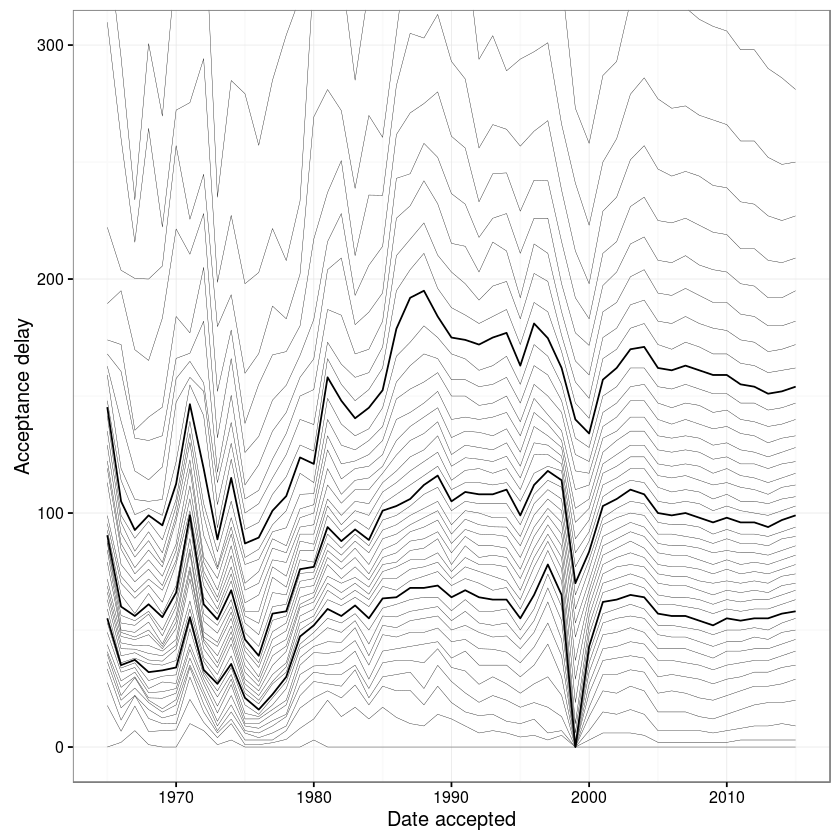

In [260]:
summarize_year <- function(df) {
  probs = seq(0, 1, 0.025)
  dplyr::data_frame(
    percentile = 100 * probs,
    delay = quantile(df$acceptance_delay, probs=probs),
    articles = nrow(df)
  )
}

year_df = accept_df %>%
  dplyr::mutate(year_accepted = lubridate::year(accepted)) %>%
  dplyr::group_by(year_accepted) %>%
  dplyr::do(summarize_year(.))

year_df %>%
  ggplot2::ggplot(aes(x = year_accepted, y = delay, group = percentile)) +
  ggplot2::geom_line(size=0.1) +
  ggplot2::geom_line(data = dplyr::filter(year_df, percentile %in% c(25, 50, 75)), size=0.5) +
  ggplot2::coord_cartesian(ylim = c(0, 300)) +
  ggplot2::theme_bw() +
  ggplot2::xlab('Date accepted') +
  ggplot2::ylab('Acceptance delay')

### Rolling window method

In [281]:
probs = seq(0, 1, 0.025)
width_ = 10000
by_ = 2000
n = nrow(accept_df)
res <- zoo::rollapply(accept_df$acceptance_delay[1:n], width=width_, FUN=quantile, probs=probs, by = by_) %>%
  as.data.frame()
colnames(res) = probs * 100
x <- accept_df$accepted[seq(width_/2, n - width_/2, by_)]
percentile_df = data.frame(date = x, res, check.names=FALSE) %>%
  tidyr::gather(key=percentile, value=delay, -date)

In [285]:
head(percentile_df, 2)

,date,percentile,delay
1,1979-09-21,0,0
2,1982-09-09,0,0


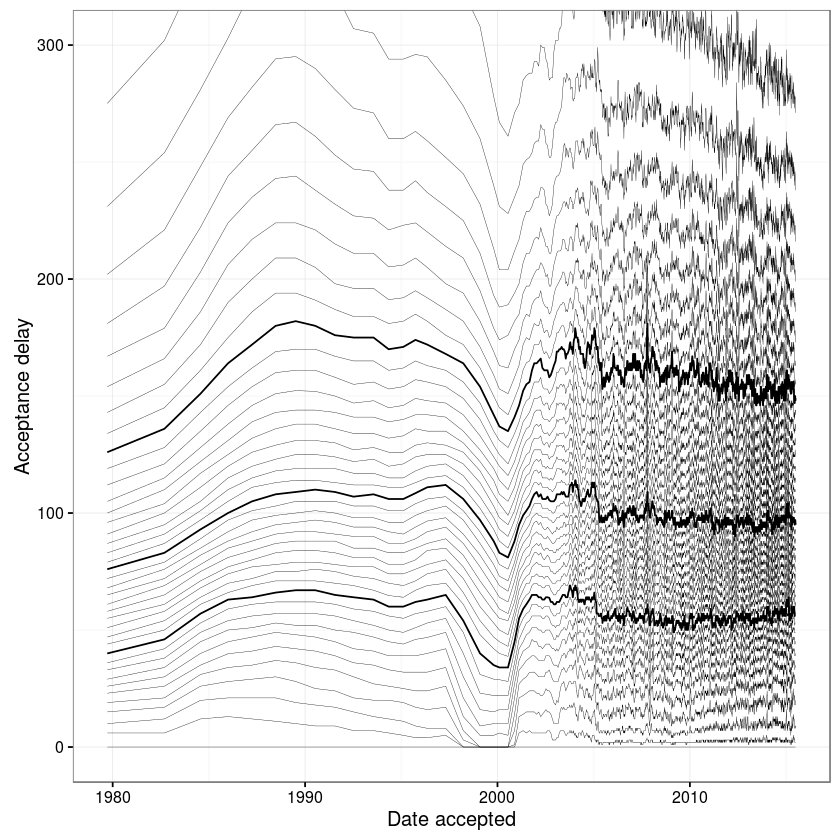

In [283]:
percentile_df %>%
  ggplot2::ggplot(aes(x = date, y = delay, group = percentile)) +
  ggplot2::geom_line(size=0.1) +
  ggplot2::geom_line(data = dplyr::filter(percentile_df, percentile %in% c(25, 50, 75)), size=0.5) +
  ggplot2::coord_cartesian(ylim = c(0, 300)) +
  ggplot2::theme_bw() +
  ggplot2::xlab('Date accepted') +
  ggplot2::ylab('Acceptance delay')

## Visualize journal delay trends

In [213]:
nlm_ids = (
  journal_df %>%
  dplyr::filter(acceptance_delays > 500) %>%
  dplyr::filter(unique_acceptance_dates > 10)
)$journal_nlm_id

gg = accept_df %>%
  dplyr::filter(journal_nlm_id %in% nlm_ids) %>%
  dplyr::mutate(accepted_decimal = lubridate::decimal_date(accepted)) %>%
  ggplot2::ggplot(aes(x = accepted_decimal, y = acceptance_delay, group=journal_nlm_id)) +
  ggplot2::geom_smooth(se = FALSE, size=0.05, color='black') +
  ggplot2::theme_bw() +
  ggplot2::xlab('Date accepted') +
  ggplot2::ylab('Acceptance delay') +
  ggplot2::coord_cartesian(xlim = c(1990, 2016), ylim = c(0, 300))

path = file.path('viz', 'journal-smooths.png')
ggplot2::ggsave(filename = path, plot = gg, width = 5.5, height = 0.75 * 5.5)

## Visualize the history of publishing delays

In [174]:
subset_df = journal_df %>%
  dplyr::filter(acceptance_delays >= 100) %>%
  dplyr::filter(unique_acceptance_dates >= 2) %>%
  dplyr::filter(unique_acceptance_delays >= 3)

for (i in 1:nrow(subset_df)) {
  nlm_id = subset_df$journal_nlm_id[i]
  journal_abbrev = subset_df$journal_abbrev[i]
  df = accept_df %>% dplyr::filter(journal_nlm_id == nlm_id)
  xlimits = boxplot.stats(df$accepted_decimal, coef = 3)$stats[c(1, 5)]
  ylimits = boxplot.stats(df$acceptance_delay, coef = 3)$stats[c(1, 5)]
  gg = df %>%
    ggplot2::ggplot(aes(x = accepted_decimal, y = acceptance_delay)) +
    ggplot2::geom_point(alpha=log(nrow(df))^-1.02 - 0.02, color='#e60000') +
    ggplot2::geom_smooth(linetype=0, fill='#454343', alpha=0.56) +
    ggplot2::coord_cartesian(xlim = xlimits, ylim = ylimits) +
    ggplot2::theme_bw() +
    ggplot2::xlab('Date accepted') +
    ggplot2::ylab('Acceptance delay') +
    ggplot2::ggtitle(label = journal_abbrev)
  path = file.path('viz', 'journal', sprintf('%s.png', nlm_id))
  ggplot2::ggsave(filename = path, plot = gg, width = 5.5, height = 0.75 * 5.5)
}

Warning message:
In simpleLoess(y, x, w, span, degree, parametric, drop.square, normalize, : pseudoinverse used at 2007.8Warning message:
In simpleLoess(y, x, w, span, degree, parametric, drop.square, normalize, : neighborhood radius 0.68709Warning message:
In simpleLoess(y, x, w, span, degree, parametric, drop.square, normalize, : reciprocal condition number  1.6048e-30Warning message:
In simpleLoess(y, x, w, span, degree, parametric, drop.square, normalize, : There are other near singularities as well. 0.4721Warning message:
In predLoess(y, x, newx, s, weights, pars$robust, pars$span, pars$degree, : pseudoinverse used at 2007.8Warning message:
In predLoess(y, x, newx, s, weights, pars$robust, pars$span, pars$degree, : neighborhood radius 0.68709Warning message:
In predLoess(y, x, newx, s, weights, pars$robust, pars$span, pars$degree, : reciprocal condition number  1.6048e-30Warning message:
In predLoess(y, x, newx, s, weights, pars$robust, pars$span, pars$degree, : There are other ne